## Import

In [377]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier
import re

## Data Load

In [378]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [379]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               748 non-null    object 
 1   generation                       748 non-null    int64  
 2   school1                          748 non-null    int64  
 3   major type                       726 non-null    object 
 4   major1_1                         728 non-null    object 
 5   major1_2                         309 non-null    object 
 6   major_data                       748 non-null    bool   
 7   job                              748 non-null    object 
 8   class1                           748 non-null    int64  
 9   class2                           169 non-null    float64
 10  class3                           14 non-null     float64
 11  class4                           1 non-null      float64
 12  re_registration       

**Insight**
1. previous_class_3~8 : non-null 개수가 동일함

     -한 번이라도 이전 기수에 들은 경험이 있는 사람이면, 
     - 안 들은 기수는 '해당없음'을 넣고, 들은 기수는 분반명 (예시= 0001 : 파이썬 문법 기초반)이 기입돼있음
     -특기할 점은, 이전에 들은 경험이 있는 사람은 같은 강좌를 여러 번 듣는 게 아니라 다른 강좌를 듣고 와서 또 듣는 식이라 수료율이 매우 높음!!

2. class1~class4
 - 이번 기수에 듣는 분반(강좌)번호
 - 여러 개 듣는 경우(4개까지) -> class1부터 class4까지 하나씩 분반숫자를 기입
 - 따라서 class3, class4는 대부분 결측치
 - 오름차순으로 적는 것이므로 같은 분반 번호가 class1에 적히나 class4에 적히나 차이가 없음
 - One-Hot encoding으로 분반을 처리하는 등의 조치가 필요해보임 (test dataset에는 trainset에 등장하지 않은 분반이 등장함에 유의)
 - 여러 강좌를 듣는 사람(3개 동시 수강)의 경우 수료율이 높아 보임 -> 몇 개 분반을 듣는 지를 변수로 추가

 3. contest_award, contest_participation, idea_contest는 training set이나 test set에서 채워진 행이 단 하나도 없음 -> 당연히 컬럼 삭제

 4. 응답 형태가 다양한 컬럼 (희망회사명, 현직자 강의 규모 선택 이유)은 한국어NLP모델을 사용하여 분석하지 않는 이상, 과감히 없애는 게 나아보임.
  - 희망회사명은 '없음', '모르겠음', 'NaN' 등의 결과인지만 체크하는 식으로 가공하는 것도 좋아보임.
  - 아직 명확한 희망직무가 없는 사람이므로 수료할 가능성이 낮다고 볼 수 있기 때문

**왤케 머할지 모르겠고 막막하냐.. ㅜㅜ 일단 변수를 하나씩 컨트롤해봅시다**

In [380]:
drop_cols = ['ID', 'generation', 'contest_award', 'contest_participation', 'idea_contest']

## school1 변수
- int64 type이지만 실제로는 범주형 변수 (모델이 숫자를 '크기'로 인식하게 하면 안됨)
- training set에는 없지만 test set에는 있거나, training set에 매우 적은 수로 존재하는 학교를 '기타'로 처리
- 이후 'category' type으로 처리하도록 하여 XGBClassifier 모델이 인식할 수 있도록 함.

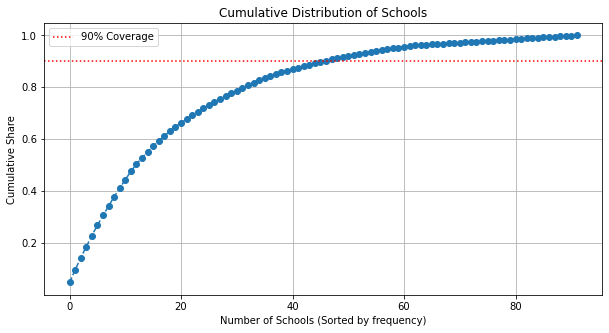

In [381]:
# 학교별 빈도수 계산 및 정렬
school_counts = train['school1'].value_counts()
# 누적 합계 및 비율 계산
cumulative_shares = school_counts.cumsum() / len(train)

plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_shares)), cumulative_shares.values, marker='o', linestyle='--')
plt.axhline(y=0.9, color='r', linestyle=':', label='90% Coverage') # 90% 선
plt.title('Cumulative Distribution of Schools')
plt.xlabel('Number of Schools (Sorted by frequency)')
plt.ylabel('Cumulative Share')
plt.legend()
plt.grid(True)
plt.show()

In [382]:
# 빈도 구간별 학교 수 확인
print(f"전체 학교 수: {len(school_counts)}")
for i in range(1, 6):
    num_schools = len(school_counts[school_counts <= i])
    percentage = (school_counts[school_counts <= i].sum() / len(train)) * 100
    print(f"빈도가 {i}번 이하인 학교 수: {num_schools}개 (전체 데이터의 {percentage:.2f}%)")

전체 학교 수: 92
빈도가 1번 이하인 학교 수: 29개 (전체 데이터의 3.88%)
빈도가 2번 이하인 학교 수: 35개 (전체 데이터의 5.48%)
빈도가 3번 이하인 학교 수: 43개 (전체 데이터의 8.69%)
빈도가 4번 이하인 학교 수: 51개 (전체 데이터의 12.97%)
빈도가 5번 이하인 학교 수: 55개 (전체 데이터의 15.64%)


In [383]:
# 기준 설정: 예를 들어 5명 미만인 학교는 '기타'로 분류
# 이 숫자는 EDA를 통해 적절히 조절 가능합니다.
school_threshold = 3
common_schools = school_counts[school_counts >= school_threshold].index.tolist()

def preprocess_school(df, common_list):
    # copy를 사용하여 원본 데이터 훼손 방지
    new_df = df.copy()
    
    # common_list에 없는 학교는 모두 -1 (또는 특정 숫자)로 통일
    # 훈련 데이터의 희소 학교 + 테스트 데이터의 새로운 학교가 모두 -1이 됨
    new_df['school1_grouped'] = new_df['school1'].apply(lambda x: x if x in common_list else -1)
    
    return new_df

# 변환 적용
train = preprocess_school(train, common_schools)
test = preprocess_school(test, common_schools)

# 결과 확인
print(f"변환 후 Train 내 유니크 학교 수: {train['school1_grouped'].nunique()}")
print(f"변환 후 Test 내 유니크 학교 수: {test['school1_grouped'].nunique()}")

# 기존의 school1_grouped (정수형)를 카테고리 타입으로 바꾸고, 기존 school1 컬럼 없애기
train['school1_grouped'] = train['school1_grouped'].astype('category')
test['school1_grouped'] = test['school1_grouped'].astype('category')
drop_cols.append('school1')

변환 후 Train 내 유니크 학교 수: 58
변환 후 Test 내 유니크 학교 수: 58


## 전공관련 변수 전처리
- major type, major1_1, major1_2 없애기
- major_field에서 결측치 처리하고, 콤마(',') 기준으로 문자열 나눈 후 해당 문자열을 가지고 있는지를 체크
- major_data: bool 변수 -> int로 변경

In [384]:
drop_cols += ['major type', 'major1_1', 'major1_2']
# '자연고학'이라는 글자를 찾아서 '자연과학'으로 변경 
# regex=False를 설정하여 단순 문자열 치환임을 명시 (성능 및 안정성 향상)
train['major_field'] = train['major_field'].str.replace('자연고학', '자연과학', regex=False)

# (만약 테스트 셋에도 있을 수 있으니 동일하게 적용)
test['major_field'] = test['major_field'].str.replace('자연고학', '자연과학', regex=False)

# 문자열을 리스트로 변환하는 함수 정의
def tokenize_major(text):
    if pd.isna(text):
        return []
    # 쉼표로 분리 + 콤마 뒤쪽 공백 제거 (예: '자연과학, 사회과학'-> ['자연과학', '사회과학'])
    return [item.strip() for item in str(text).split(',')]

# 전공 리스트 컬럼 생성
train['major_list'] = train['major_field'].apply(tokenize_major)
test['major_list'] = test['major_field'].apply(tokenize_major)

# MultiLabelBinarizer 학습 및 변환
mlb = MultiLabelBinarizer()

# Train 데이터로 기준(클래스)을 잡고 변환
train_encoded = mlb.fit_transform(train['major_list'])

# Test 데이터는 Train에서 만든 기준에 맞춰 변환만 수행
# (Train에 없던 전공이 Test에 나올 경우 무시됨 - 일관성 유지)
test_encoded = mlb.transform(test['major_list'])

# 데이터프레임으로 변환하여 기존 데이터와 결합
major_columns = [f'major_{c}' for c in mlb.classes_]

train_major_df = pd.DataFrame(train_encoded, columns=major_columns, index=train.index)
test_major_df = pd.DataFrame(test_encoded, columns=major_columns, index=test.index)
print(f"생성된 전공 컬럼들: {major_columns}")
train = pd.concat([train, train_major_df], axis=1)
test = pd.concat([test, test_major_df], axis=1)

# 불필요해진 원본 및 중간 컬럼 삭제
drop_cols += ['major_field', 'major_list']

print(f"새로 생성된 전공 컬럼 개수: {len(major_columns)}개")

# major_data 컬럼을 bool형에서 정수형으로 변환
train['major_data'] = train['major_data'].astype(int)

생성된 전공 컬럼들: ['major_IT (컴퓨터 공학 포함)', 'major_경영학', 'major_경제통상학', 'major_공학 (컴퓨터 공학 제외)', 'major_교육학', 'major_법학', 'major_사회과학', 'major_예체능', 'major_의약학', 'major_인문학', 'major_자연과학']
새로 생성된 전공 컬럼 개수: 11개


## Job 전처리

In [385]:
# 빈도수가 5회 미만인 직업은 '기타'로 통합
job_counts = train['job'].value_counts()
rare_jobs = job_counts[job_counts < 5].index.tolist()
print(f"빈도수가 5회 미만인 직업들: {rare_jobs}")

빈도수가 5회 미만인 직업들: []


In [386]:
# job 컬럼을 'category' 타입으로 변환
train['job'] = train['job'].astype('category')
test['job'] = test['job'].astype('category')

## Class1 ~ Class4 전처리

In [387]:
def check_class_distribution(df, name="Dataset"):
    # 4개 컬럼의 값을 하나로 합침 (결측치 제외)
    all_classes = df[['class1', 'class2', 'class3', 'class4']].values.flatten()
    all_classes = all_classes[~pd.isna(all_classes)]
    
    # 빈도수 계산
    dist = pd.Series(all_classes).value_counts().sort_index()
    
    print(f"--- {name} Class Distribution ---")
    print(f"Total Unique Classes: {len(dist)}")
    print(f"Class Range: {dist.index.min()} ~ {dist.index.max()}")
    print(dist)
    print("\n")

# 실행
check_class_distribution(train, "Train")
check_class_distribution(test, "Test")

--- Train Class Distribution ---
Total Unique Classes: 10
Class Range: 1.0 ~ 13.0
1.0     128
2.0     149
4.0     180
5.0     108
6.0      96
7.0      66
8.0      78
11.0     30
12.0     41
13.0     56
dtype: int64


--- Test Class Distribution ---
Total Unique Classes: 11
Class Range: 1.0 ~ 16.0
1.0     102
2.0     187
4.0     180
5.0     138
6.0      82
7.0      73
8.0      64
12.0     55
14.0     72
15.0    116
16.0     40
dtype: int64




In [388]:
def preprocess_classes(train_df, test_df):
    """
    class1~class4 컬럼을 기반으로 수강 강좌 수(class_count)를 생성하고,
    실제 관측된 분반 번호들만 추출하여 Multi-Label One-Hot Encoding을 수행합니다.
    """
    class_cols = ['class1', 'class2', 'class3', 'class4']
    
    # 1. 수강 강좌 수(Feature) 생성
    train_df['class_count'] = train_df[class_cols].notna().sum(axis=1)
    test_df['class_count'] = test_df[class_cols].notna().sum(axis=1)

    # 2. 각 행의 분반 번호를 리스트로 추출 (정수형 변환)
    def get_class_list(row):
        return [int(x) for x in row if pd.notna(x)]

    train_lists = train_df[class_cols].apply(get_class_list, axis=1)
    test_lists = test_df[class_cols].apply(get_class_list, axis=1)

    # 3. Train과 Test에서 실제 관측된 모든 분반 번호의 합집합 추출 (3번 등 미등장 번호 자동 제외)
    train_observed = set([c for sublist in train_lists for c in sublist])
    test_observed = set([c for sublist in test_lists for c in sublist])
    final_classes = sorted(list(train_observed | test_observed))

    # 4. MultiLabelBinarizer 적용 (명시적인 클래스 범위 지정)
    mlb = MultiLabelBinarizer(classes=final_classes)
    
    # Train 데이터 기반 학습 및 변환, Test 데이터는 동일 기준 변환
    train_encoded = mlb.fit_transform(train_lists)
    test_encoded = mlb.transform(test_lists)

    # 5. 인코딩된 결과를 데이터프레임으로 변환 및 결합
    class_columns = [f'class_{c}' for c in mlb.classes_]
    
    train_encoded_df = pd.DataFrame(train_encoded, columns=class_columns, index=train_df.index)
    test_encoded_df = pd.DataFrame(test_encoded, columns=class_columns, index=test_df.index)

    train_df = pd.concat([train_df, train_encoded_df], axis=1)
    test_df = pd.concat([test_df, test_encoded_df], axis=1)

    return train_df, test_df

# 실행 및 원본 컬럼 관리
train, test = preprocess_classes(train, test)
drop_cols.extend(['class1', 'class2', 'class3', 'class4'])

## re-registration

In [389]:
# 계속 재사용할 함수!!
def check_col_distribution(train_df, test_df, col):
    print(f"--- {col} 분포 확인 ---")
    print(f"\n[Train]")
    print(train_df[col].value_counts(dropna=False))
    
    print(f"\n[Test]")
    print(test_df[col].value_counts(dropna=False))
    
    # 두 셋의 유니크 값 차이 확인
    train_vals = set(train_df[col].unique())
    test_vals = set(test_df[col].unique())
    
    if train_vals != test_vals:
        print(f"\n[Warning] 불일치 발견!")
        print(f"Train에만 있음: {train_vals - test_vals}")
        print(f"Test에만 있음: {test_vals - train_vals}")
    else:
        print(f"\n[Info] Train/Test의 범주가 일치합니다.")

# 실행
check_col_distribution(train, test, 're_registration')

--- re_registration 분포 확인 ---

[Train]
아니요    602
예      146
Name: re_registration, dtype: int64

[Test]
아니요    659
예      155
Name: re_registration, dtype: int64

[Info] Train/Test의 범주가 일치합니다.


In [390]:
# 1. 매핑 딕셔너리 생성
# '아니요'는 0(신규), '예'는 1(재등록)로 설정합니다.
re_reg_map = {'아니요': 0, '예': 1}

# 2. Train 및 Test 데이터 변환
train['re_registration'] = train['re_registration'].map(re_reg_map)
test['re_registration'] = test['re_registration'].map(re_reg_map)

# 3. 데이터 타입 정수형(int) 확정
# 결측치가 발생할 경우를 대비해 fillna(0)를 포함하는 것이 안전합니다.
train['re_registration'] = train['re_registration'].fillna(0).astype(int)
test['re_registration'] = test['re_registration'].fillna(0).astype(int)

### Nationality

In [391]:
check_col_distribution(train, test, 'nationality')

--- nationality 분포 확인 ---

[Train]
내국인    745
외국인      2
NaN      1
Name: nationality, dtype: int64

[Test]
내국인    810
외국인      4
Name: nationality, dtype: int64

[Warning] 불일치 발견!
Train에만 있음: {nan}
Test에만 있음: set()


- 외국인 사실상 없는 수준 -> 컬럼 삭제

In [392]:
drop_cols += ['nationality']

## Inflow Route

In [393]:
check_col_distribution(train, test, 'inflow_route')

--- inflow_route 분포 확인 ---

[Train]
에브리타임                               340
기존 학회원 또는 운영진                       150
인스타그램                               121
지인 추천                                78
대외활동 사이트(링커리어, 캠퍼스픽, 캠퍼즈, 위비티 등)     55
기타                                    2
교내 플랫폼 (에브리타임 X)                      1
인터넷 검색                                1
Name: inflow_route, dtype: int64

[Test]
에브리타임                               419
인스타그램                               156
기존 BDA 오픈채팅방                         89
지인 추천                                77
대외활동 사이트(링커리어, 캠퍼스픽, 캠퍼즈, 위비티 등)     62
직장인 커뮤니티(블라인드, 링크드인 등)                5
B.D.A 행사 (잡페스티벌, WAVE)                2
기존 BDA 학회원                            1
인터넷 검색                                1
bda 9기활동                              1
네이버 블로그                               1
Name: inflow_route, dtype: int64

[Warning] 불일치 발견!
Train에만 있음: {'교내 플랫폼 (에브리타임 X)', '기존 학회원 또는 운영진', '기타'}
Test에만 있음: {'네이버 블로그', '기존 BDA 학회원', '직장인 커뮤니티(블라인드, 링크

In [394]:
def preprocess_inflow_route(train_df, test_df, threshold=10):
    # 1. '기존' 키워드가 포함된 유입 경로 통합
    def unify_existing(x):
        if pd.isna(x):
            return '기타'
        if '기존' in str(x):
            return '기존_유입'
        return x

    train_df['inflow_route'] = train_df['inflow_route'].apply(unify_existing)
    test_df['inflow_route'] = test_df['inflow_route'].apply(unify_existing)

    # 2. Train 데이터 기준으로 빈도수 계산
    route_counts = train_df['inflow_route'].value_counts()
    
    # 빈도가 threshold(10) 이상인 경로들만 추출
    common_routes = route_counts[route_counts >= threshold].index.tolist()

    # 3. 10개 미만인 데이터 및 Test에만 있는 새로운 경로는 '기타'로 통합
    def group_rare_routes(x):
        if x in common_routes:
            return x
        return '기타'

    train_df['inflow_route'] = train_df['inflow_route'].apply(group_rare_routes)
    test_df['inflow_route'] = test_df['inflow_route'].apply(group_rare_routes)

    # 4. XGBoost를 위해 category 타입으로 변환
    train_df['inflow_route'] = train_df['inflow_route'].astype('category')
    test_df['inflow_route'] = test_df['inflow_route'].astype('category')

    return train_df, test_df

# 전처리 실행
train, test = preprocess_inflow_route(train, test)

# 결과 확인
print("전처리 후 Train 유입 경로 분포:\n", train['inflow_route'].value_counts())
print("\n전처리 후 Test 유입 경로 분포:\n", test['inflow_route'].value_counts())

전처리 후 Train 유입 경로 분포:
 에브리타임                               340
기존_유입                               150
인스타그램                               121
지인 추천                                78
대외활동 사이트(링커리어, 캠퍼스픽, 캠퍼즈, 위비티 등)     55
기타                                    4
Name: inflow_route, dtype: int64

전처리 후 Test 유입 경로 분포:
 에브리타임                               419
인스타그램                               156
기존_유입                                90
지인 추천                                77
대외활동 사이트(링커리어, 캠퍼스픽, 캠퍼즈, 위비티 등)     62
기타                                   10
Name: inflow_route, dtype: int64


## what_to_gain & hope_for_group

In [395]:
check_col_distribution(train, test, 'what_to_gain')
check_col_distribution(train, test, 'hope_for_group')

--- what_to_gain 분포 확인 ---

[Train]
데이터 분석 역량                                                                          492
프로젝트 경험                                                                            149
공모전 경험                                                                              73
인적 네트워크                                                                             29
기초적인 python, sql 지식 숙지                                                               1
위 항목 전체                                                                              1
공모전과 프로젝트                                                                            1
사실 한가지를 고르기 어렵습니다..ㅠㅠ 학회를 통해 위의 4가지와 협업에 계신 전문가님들에게 유익한 정보를 얻고 소중한 경험을 하고 싶습니다.      1
분석 역량, 공모전 경험, 인적 네트워크                                                               1
Name: what_to_gain, dtype: int64

[Test]
데이터 분석 역량                                                                        502
프로젝트 경험                                                

In [396]:
def preprocess_categorical_col(train_df, test_df, col_name, threshold=10):
    """
    특정 컬럼에서 빈도가 낮은(10개 미만) 항목을 '기타'로 통합하고
    category 타입으로 변환합니다.
    """
    # 1. Train 데이터 기준으로 빈도수 계산
    gain_counts = train_df[col_name].value_counts()
    
    # 10개 이상 등장하는 주요 항목 리스트 추출
    common_gains = gain_counts[gain_counts >= threshold].index.tolist()

    # 2. 통합 함수 정의
    # 주요 항목에 포함되지 않거나 Test에만 등장하는 새로운 값은 '기타'로 처리
    def group_rare_gains(x):
        if x in common_gains:
            return x
        return '기타'

    # 3. 변환 적용
    train_df[col_name] = train_df[col_name].apply(group_rare_gains)
    test_df[col_name] = test_df[col_name].apply(group_rare_gains)

    # 4. XGBoost 활용을 위해 category 타입으로 변환
    train_df[col_name] = train_df[col_name].astype('category')
    test_df[col_name] = test_df[col_name].astype('category')

    return train_df, test_df

# 전처리 실행
train, test = preprocess_categorical_col(train, test, 'what_to_gain')

# 결과 확인
print("전처리 후 Train 얻고자 하는 것 분포:\n", train['what_to_gain'].value_counts())
print("\n전처리 후 Test 얻고자 하는 것 분포:\n", test['what_to_gain'].value_counts())

전처리 후 Train 얻고자 하는 것 분포:
 데이터 분석 역량    492
프로젝트 경험      149
공모전 경험        73
인적 네트워크       29
기타             5
Name: what_to_gain, dtype: int64

전처리 후 Test 얻고자 하는 것 분포:
 데이터 분석 역량    502
프로젝트 경험      198
공모전 경험        79
인적 네트워크       32
기타             3
Name: what_to_gain, dtype: int64


In [397]:
train['hope_for_group'] = train['hope_for_group'].astype('category')
test['hope_for_group'] = test['hope_for_group'].astype('category')

## previous_class3~8
- 이전에 수업 몇 번 들었는지 체크 (prev_attendance_count)
- 위에서 만들었던 re_registration 변수의 정보가 여기에 포함되므로 그냥 삭제

In [398]:
def create_experience_feature(df):
    # 1. 대상 컬럼 리스트 정의
    prev_cols = [f'previous_class_{i}' for i in range(3, 9)]
    
    # 2. 누적 참여 횟수 계산
    # '없음'이 아니면서 결측치도 아닌 경우를 카운트
    df['prev_attendance_count'] = df[prev_cols].apply(
        lambda x: (x != '해당없음') & (x.notna()), axis=1
    ).sum(axis=1)
    
    return df

# Train 및 Test 적용
train = create_experience_feature(train)
test = create_experience_feature(test)

# 결과 확인
print("참여 횟수별 데이터 수 (Train):\n", train['prev_attendance_count'].value_counts())

drop_cols += ['previous_class_3', 'previous_class_4', 'previous_class_5',
              'previous_class_6', 'previous_class_7', 'previous_class_8', 're_registration']

참여 횟수별 데이터 수 (Train):
 0    603
1    117
2     21
3      5
6      1
4      1
Name: prev_attendance_count, dtype: int64


## desired_career_path / completed_semester

In [399]:
check_col_distribution(train, test, 'desired_career_path')
check_col_distribution(train, test, 'completed_semester')

--- desired_career_path 분포 확인 ---

[Train]
취업        573
대학원 진학    143
이직         24
창업          8
Name: desired_career_path, dtype: int64

[Test]
취업          601
대학원 진학      169
이직           26
창업            9
현재 직장 유지      9
Name: desired_career_path, dtype: int64

[Warning] 불일치 발견!
Train에만 있음: set()
Test에만 있음: {'현재 직장 유지'}
--- completed_semester 분포 확인 ---

[Train]
6.00        205
8.00        193
4.00        134
7.00         74
5.00         40
2.00         29
NaN          28
9.00         20
3.00         10
10.00         9
20241.00      2
1.00          2
2020.02       1
0.00          1
Name: completed_semester, dtype: int64

[Test]
5.0     170
7.0     168
8.0     154
6.0      90
NaN      74
3.0      63
4.0      41
9.0      30
2.0      11
10.0      9
1.0       4
Name: completed_semester, dtype: int64

[Warning] 불일치 발견!
Train에만 있음: {nan, 0.0, 2020.02, 20241.0}
Test에만 있음: {nan}


In [400]:
train, test = preprocess_categorical_col(train, test, 'desired_career_path')

- 'semester' 컬럼을 남기는 게 좋을지 상관계수 및 p-value를 통해 확인

In [401]:
# 이상치(Outlier)를 NaN으로 처리하거나 적절한 값으로 수정
# 10학기를 초과하는 값은 상식적인 이수 학기를 벗어나므로 NaN 처리 후 나중에 채우는 것이 안전합니다.
def clean_semester(df):
    # 1. 상식적인 범위를 벗어나는 값(예: 12학기 초과)은 NaN으로 변환
    df['completed_semester'] = df['completed_semester'].apply(
        lambda x: x if (pd.notna(x) and 0 <= x <= 12) else np.nan
    )
    return df

# 중앙값으로 채우기 (정수 형태 유지를 위해)
semester_median = train['completed_semester'].median()
train['completed_semester'] = train['completed_semester'].fillna(semester_median)
test['completed_semester'] = test['completed_semester'].fillna(semester_median)

train = clean_semester(train)
test = clean_semester(test)

# NaN을 제외하고 계산
mask = train['completed_semester'].notna()
pb_corr = stats.pointbiserialr(train['completed_semester'][mask], train['completed'][mask])
print(f"Point-Biserial 상관계수: {pb_corr.correlation:.4f} (p-value: {pb_corr.pvalue:.4e})")

Point-Biserial 상관계수: 0.0776 (p-value: 3.4295e-02)


- 선형성은 낮지만, p-value가 유의미하게 나왔으므로 Low, Middle, High의 구간으로 나누기로 함.

In [402]:
def bin_semester(x):
    if x <= 3: return 'Low'      # 1~2학년 초반
    if x <= 6: return 'Middle'   # 2학년 후반~3학년
    return 'High'                # 4학년 이상

# 새로운 피처 생성
train['semester_group'] = train['completed_semester'].apply(bin_semester).astype('category')
test['semester_group'] = test['completed_semester'].apply(bin_semester).astype('category')

drop_cols += ['completed_semester']

In [403]:
check_col_distribution(train, test, 'project_type')
train['project_type'] = train['project_type'].astype('category')
test['project_type'] = test['project_type'].astype('category')

--- project_type 분포 확인 ---

[Train]
팀     527
개인    221
Name: project_type, dtype: int64

[Test]
팀     576
개인    238
Name: project_type, dtype: int64

[Info] Train/Test의 범주가 일치합니다.


## time_input

In [404]:
print(train['time_input'].describe())
correlation = train['time_input'].corr(train['completed'])
print(f"입력 시간과 수료 여부의 상관계수: {correlation:.4f}")

count    748.000000
mean       2.326471
std        1.365925
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       24.000000
Name: time_input, dtype: float64
입력 시간과 수료 여부의 상관계수: 0.0261


In [405]:
# 1. IQR 기반 아웃라이어 임계값 계산
Q1 = train['time_input'].quantile(0.25)
Q3 = train['time_input'].quantile(0.75)
IQR = Q3 - Q1
upper_fence = Q3 + 1.5 * IQR

print(f"통계적 아웃라이어 기준(Upper Fence): {upper_fence} 시간 초과")

# 2. 데이터 분리
normal_group = train[train['time_input'] <= upper_fence]
outlier_group = train[train['time_input'] > upper_fence]

# 3. 각 그룹별 상관계수 및 수료율 확인
def analyze_group(df, name):
    corr = df['time_input'].corr(df['completed'])
    mean_comp = df['completed'].mean()
    count = len(df)
    print(f"\n[{name} 그룹 분석]")
    print(f"데이터 개수: {count}개")
    print(f"평균 수료율: {mean_comp:.4f}")
    print(f"시간-수료 상관계수: {corr:.4f}")

analyze_group(normal_group, "정상")
analyze_group(outlier_group, "아웃라이어")

# 4. (추가 팁) 시간대별 수료율 시각화 테이블
print("\n[시간 입력값별 수료율 상세]")
print(train.groupby('time_input')['completed'].agg(['mean', 'count']))

통계적 아웃라이어 기준(Upper Fence): 4.5 시간 초과

[정상 그룹 분석]
데이터 개수: 715개
평균 수료율: 0.2993
시간-수료 상관계수: 0.0191

[아웃라이어 그룹 분석]
데이터 개수: 33개
평균 수료율: 0.2727
시간-수료 상관계수: 0.2119

[시간 입력값별 수료율 상세]
                mean  count
time_input                 
0.0         0.500000      4
0.7         0.000000      1
1.0         0.333333    117
1.5         0.235294     17
2.0         0.278481    395
2.5         0.000000      2
3.0         0.305785    121
4.0         0.379310     58
5.0         0.300000     20
6.0         0.125000      8
7.0         1.000000      1
8.0         0.000000      1
10.0        0.000000      2
24.0        1.000000      1


In [406]:
def preprocess_time_input(train_df, test_df):
    """
    time_input 컬럼을 4개 그룹으로 구간화하고 
    XGBoost 학습에 최적화된 category 타입으로 변환합니다.
    """
    # 1. 구간 분류 로직 정의
    def get_time_group(x):
        if pd.isna(x): return 'Group_0' # 결측치 처리 (필요시)
        if x <= 1:
            return 'Group_0'  # 1시간 이하
        elif x < 3:
            return 'Group_1'  # 1시간 초과 3시간 미만
        elif x < 6:
            return 'Group_2'  # 3시간 이상 6시간 미만
        else:
            return 'Group_3'  # 6시간 이상

    # 2. Train/Test 데이터에 공통 적용
    # 숫자가 아닌 문자열 라벨을 부여하여 명확하게 범주형임을 명시합니다.
    for df in [train_df, test_df]:
        df['time_group'] = df['time_input'].apply(get_time_group).astype('category')

    # 3. 그룹별 수료율 통계 출력 (Train 기준 검증)
    group_stats = train_df.groupby('time_group', observed=True)['completed'].agg(['mean', 'count']).reset_index()
    print("--- [검증] 그룹별 수료율 분석 ---")
    print(group_stats)
    
    return train_df, test_df

# 전처리 실행
train, test = preprocess_time_input(train, test)
# 불필요한 원본 컬럼 제거
drop_cols.append('time_input')

--- [검증] 그룹별 수료율 분석 ---
  time_group      mean  count
0    Group_1  0.275362    414
1    Group_2  0.326633    199
2    Group_3  0.230769     13
3    Group_0  0.336066    122


## why_BDA

In [407]:
check_col_distribution(train, test, 'whyBDA')

--- whyBDA 분포 확인 ---

[Train]
혼자 공부하기 어려워서                                         271
큰 규모인 만큼, 커리큘럼이나 운영 등 관리가 잘 될것 같아서                   159
이전 기수에 매우 만족해서                                       146
BDA 학회원만의 혜택을 누리고 싶어서(현직자 강연, 잡 페스티벌, 기업연계 공모전 등)     64
현직자의 강의를 듣고 싶어서                                       56
시간적으로 부담이 없어서                                         29
학회 가입 시 코딩 테스트, 면접 등을 보지 않아서                          23
Name: whyBDA, dtype: int64

[Test]
혼자 공부하기 어려워서                                         377
큰 규모인 만큼, 커리큘럼이나 운영 등 관리가 잘 될것 같아서                   164
BDA 학회원만의 혜택을 누리고 싶어서(현직자 강연, 잡 페스티벌, 기업연계 공모전 등)     82
현직자의 강의를 듣고 싶어서                                       75
시간적으로 부담이 없어서                                         67
학회 가입 시 코딩 테스트, 면접 등을 보지 않아서                          46
현직자 강연 등 BDA 학회원의 혜택과 큰 규모인 만큼 관리가 잘 될 것 같다는 기대        1
강연, 기업연계 및 공모전 참여로 능력 향상                               1
학교에 빅데이터 학회가 없어서                                       1
Name: whyBDA, dtype: in

In [408]:
# Test에만 있는 소수 데이터를 Train에 있는 유사한 항목으로 치환
def map_rare_why(text):
    if pd.isna(text):
        return '기타' # 혹은 최빈값
    text = str(text)
    
    # 1. 혜택 관련 키워드 포함 시 -> 혜택 그룹으로
    if '혜택' in text or '강연' in text or '기업연계' in text:
        return 'BDA 학회원만의 혜택을 누리고 싶어서(현직자 강연, 잡 페스티벌, 기업연계 공모전 등)'
    
    # 2. 학교에 없거나 공부 관련 -> 혼자 공부하기 어려워서
    if '학교' in text or '능력 향상' in text:
        return '혼자 공부하기 어려워서'
        
    return text

# 적용 먼저 하고 -> 그 다음 빈도수 컷(Threshold) 적용
train['whyBDA'] = train['whyBDA'].apply(map_rare_why)
test['whyBDA'] = test['whyBDA'].apply(map_rare_why)

# 이후 기존 로직대로 preprocess_categorical_col 함수 실행
# 전처리 실행
train, test = preprocess_categorical_col(train, test, 'whyBDA')

# 결과 확인
print("전처리 후 Train 왜 BDA를 선택했는지 분포:\n", train['whyBDA'].value_counts())
print("\n전처리 후 Test 왜 BDA를 선택했는지 분포:\n", test['whyBDA'].value_counts())

전처리 후 Train 왜 BDA를 선택했는지 분포:
 혼자 공부하기 어려워서                                         271
큰 규모인 만큼, 커리큘럼이나 운영 등 관리가 잘 될것 같아서                   159
이전 기수에 매우 만족해서                                       146
BDA 학회원만의 혜택을 누리고 싶어서(현직자 강연, 잡 페스티벌, 기업연계 공모전 등)     64
현직자의 강의를 듣고 싶어서                                       56
시간적으로 부담이 없어서                                         29
학회 가입 시 코딩 테스트, 면접 등을 보지 않아서                          23
Name: whyBDA, dtype: int64

전처리 후 Test 왜 BDA를 선택했는지 분포:
 혼자 공부하기 어려워서                                         378
큰 규모인 만큼, 커리큘럼이나 운영 등 관리가 잘 될것 같아서                   164
BDA 학회원만의 혜택을 누리고 싶어서(현직자 강연, 잡 페스티벌, 기업연계 공모전 등)     84
현직자의 강의를 듣고 싶어서                                       75
시간적으로 부담이 없어서                                         67
학회 가입 시 코딩 테스트, 면접 등을 보지 않아서                          46
Name: whyBDA, dtype: int64


## desired_job

In [409]:
check_col_distribution(train, test, 'desired_job')

--- desired_job 분포 확인 ---

[Train]
B. 데이터 분석가                                               133
B. 데이터 분석가, C. 데이터 사이언티스트                                 59
A. 데이터 엔지니어, B. 데이터 분석가, C. 데이터 사이언티스트                    49
C. 데이터 사이언티스트                                             43
B. 데이터 분석가, I. 마케터                                        21
                                                        ... 
I. 마케터,                                                    1
B. 데이터 분석가, D. 인공지능 전문가, E. 소프트웨어 개발자, G. PM/서비스 기획자       1
DX(디지털 트랜스포메이션)직무 희망                                       1
A. 데이터 엔지니어, B. 데이터 분석가, C. 데이터 사이언티스트, H. 자연과학계열 연구자      1
G. PM/서비스 기획자, I. 마케터, J. MD                               1
Name: desired_job, Length: 174, dtype: int64

[Test]
B. 데이터 분석가                                      376
C. 데이터 사이언티스트                                   132
D. 인공지능 전문가                                      61
A. 데이터 엔지니어                                      59
I. 마케터                           

In [410]:
def process_desired_job(df):
    # 1. 텍스트 정규화 (소문자 변환, 결측치 처리)
    df['desired_job'] = df['desired_job'].fillna('미정').astype(str)
    
    # 2. 새로운 플래그 변수 생성 (초기화)
    # 한 사람이 여러 관심사를 가질 수 있으므로 각각의 컬럼을 만듭니다.
    df['job_data_ai'] = 0    # 데이터, AI, 엔지니어
    df['job_dev'] = 0        # 개발, SW, 보안
    df['job_biz'] = 0        # 기획, 마케팅, 경영
    df['job_domain'] = 0     # 연구, 반도체, 금융, 품질 등 도메인 전문가
    df['job_undecided'] = 0  # 미정
    
    def tagging(text):
        flags = {'data': 0, 'dev': 0, 'biz': 0, 'domain': 0, 'undecided': 0}
        
        # A~J 태그 및 키워드 기반 매핑
        # (1) Data/AI 관련
        if any(x in text for x in ['A.', 'B.', 'C.', 'D.', '데이터', 'AI', '인공지능', 'Deep Learning']):
            flags['data'] = 1
            
        # (2) Dev/Tech 관련
        if any(x in text for x in ['E.', 'F.', '소프트웨어', '개발', '웹', '보안', 'UI', 'UX']):
            flags['dev'] = 1
            
        # (3) Biz/Planning 관련
        if any(x in text for x in ['G.', 'I.', 'J.', '기획', 'PM', '마케', '경영', 'MD', '컨설턴트', '영업']):
            flags['biz'] = 1
            
        # (4) Domain/Research 관련 (가장 다양함)
        # H. 자연과학계열 연구자 포함
        domain_keywords = [
            'H.', '연구', '반도체', '공정', '품질', '금융', '금공', '은행', '회계', '계리', 
            '재무', '생산', '배터리', '로보틱스', '교사', '스포츠', 'HR', '헤드헌터', '출판', '자산'
        ]
        if any(x in text for x in domain_keywords):
            flags['domain'] = 1
            
        # (5) Undecided (위 4개에 해당 안 되고, 미정 관련 키워드일 때)
        if sum(flags.values()) == 0:
            if any(x in text for x in ['미정', '모르', '계획없음', '고민']):
                flags['undecided'] = 1
            else:
                # 정말 특이한 케이스는 Domain이나 Data 중 가까운 곳으로 보내거나 기타로 처리
                # 여기서는 '데이터 직무는 아님' 같은 케이스가 있으므로 Domain/Other로 처리
                flags['domain'] = 1 
        
        return pd.Series([flags['data'], flags['dev'], flags['biz'], flags['domain'], flags['undecided']])

    # 3. 함수 적용
    df[['job_data_ai', 'job_dev', 'job_biz', 'job_domain', 'job_undecided']] = df['desired_job'].apply(tagging)
    
    return df

# 실행
train = process_desired_job(train)
test = process_desired_job(test)

# 결과 확인
print("Train Data/AI 희망자 수:", train['job_data_ai'].sum())
print("Test Data/AI 희망자 수:", test['job_data_ai'].sum())
print("\nTest의 비정형 데이터 처리 예시:")
print(test[['desired_job', 'job_data_ai', 'job_dev', 'job_biz', 'job_domain', 'job_undecided']].iloc[5:10]) # 샘플 확인

drop_cols.append('desired_job')

Train Data/AI 희망자 수: 613
Test Data/AI 희망자 수: 634

Test의 비정형 데이터 처리 예시:
  desired_job  job_data_ai  job_dev  job_biz  job_domain  job_undecided
5  B. 데이터 분석가            1        0        0           0              0
6      I. 마케터            0        0        1           0              0
7    반도체 엔지니어            0        0        0           1              0
8  B. 데이터 분석가            1        0        0           0              0
9  B. 데이터 분석가            1        0        0           0              0


## certificate_acquisition & desired_certificate
- desired_certificate는 10여개의 행 빼고 모두 원하는 자격증을 기입해서 컬럼을 없애기로 함

In [411]:
check_col_distribution(train, test, 'certificate_acquisition')

--- certificate_acquisition 분포 확인 ---

[Train]
없음                                460
ADsP                              107
ADsP, SQLD                         66
SQLD                               48
구글 애널리스트                           11
ADsP, 빅데이터 분석 기사                    6
ADsP, SQLD, 정보처리기사                  5
정보처리기사                              5
ADsP, 정보처리기사                        4
기타                                  4
컴퓨터활용능력                             3
ADsP, 구글 애널리스트                      3
ADsP, SQLD, 구글 애널리스트                3
SQLD, 구글 애널리스트                      3
준비중: ADsP, SQLD                     2
빅데이터 분석 기사                          2
준비중                                 2
준비중: SQLD                           2
ADsP, SQLD, 빅데이터 분석 기사              2
SQLD, 정보처리기사                        2
ADsP, SQLD, 빅데이터 분석 기사, 정보처리기사      2
ADsP, 정보처리기사, 구글 애널리스트              1
태블로, 구글 애널리스트                       1
ADsP, 정보처리기사, SQLD                  1
빅데이터 분석 기사, 정보처리기사                  1
태블로

In [412]:
def preprocess_certificate(df):
    
    def encode_cert(x):
        # 1. 결측치(NaN) 처리 -> 0
        if pd.isna(x):
            return 0
        
        # 문자열로 변환
        x = str(x)
        
        # 2. 'N/A'이거나, '없음' 또는 '준비중' 텍스트가 포함되어 있으면 -> 0
        if x == 'N/A' or '없음' in x or '준비중' in x:
            return 0
        
        # 3. 그 외의 경우 (자격증 소지) -> 1
        else:
            return 1

    # 변환 함수 적용
    df['certificate_acquisition'] = df['certificate_acquisition'].apply(encode_cert)
    
    return df

# 전처리 실행
train = preprocess_certificate(train)
test = preprocess_certificate(test)

# 결과 확인
print("--- 전처리 후 Train 분포 ---")
print(train['certificate_acquisition'].value_counts())
print("\n--- 전처리 후 Test 분포 ---")
print(test['certificate_acquisition'].value_counts())

--- 전처리 후 Train 분포 ---
0    466
1    282
Name: certificate_acquisition, dtype: int64

--- 전처리 후 Test 분포 ---
0    471
1    343
Name: certificate_acquisition, dtype: int64


In [413]:
drop_cols.append('desired_certificate')

## desired_job_except_data

In [414]:
check_col_distribution(train, test, 'desired_job_except_data')

--- desired_job_except_data 분포 확인 ---

[Train]
A. 금융 / 보험 직무                                                        77
D. 소프트웨어 개발자                                                         77
B. 기획 / 전략 / 경영 직무                                                   55
G. 자연과학계열 연구자                                                        47
A. 금융 / 보험 직무, B. 기획 / 전략 / 경영 직무                                    40
                                                                     ..
B. 기획 / 전략 / 경영 직무, C. MD, E. UI/UX 디자이너, F. PM / 서비스 기획자             1
A. 금융 / 보험 직무, B. 기획 / 전략 / 경영 직무, F. PM / 서비스 기획자, G. 자연과학계열 연구자     1
D. 소프트웨어 개발자, F. PM / 서비스 기획자, G. 자연과학계열 연구자                          1
B. 기획 / 전략 / 경영 직무, C. MD, D. 소프트웨어 개발자                               1
B. 기획 / 전략 / 경영 직무, F. PM / 서비스 기획자, G. 자연과학계열 연구자                    1
Name: desired_job_except_data, Length: 99, dtype: int64

[Test]
A. 금융 / 보험 직무                                                125
D. 소프트웨어 개발자                    

In [415]:
def process_job_except_data(df):
    # 1. 결측치 처리 (NaN을 빈 문자열로 변환하여 에러 방지)
    df['desired_job_except_data'] = df['desired_job_except_data'].fillna('').astype(str)
    
    # 2. A부터 H까지 태그 정의
    # 실제 데이터에 'A.', 'B.' 형태로 들어가 있으므로 점(.)을 포함해서 찾습니다.
    tags = ['A.', 'B.', 'C.', 'D.', 'E.', 'F.', 'G.', 'H.']
    
    # 3. 각 태그별로 새로운 컬럼 생성 (1 or 0)
    for tag in tags:
        # 컬럼명 예시: job_except_A, job_except_B ...
        col_name = f"job_except_{tag[0]}" 
        
        # 해당 문자열에 태그가 포함되어 있으면 1, 아니면 0
        df[col_name] = df['desired_job_except_data'].apply(lambda x: 1 if tag in x else 0)
        
    return df

# 함수 적용
train = process_job_except_data(train)
test = process_job_except_data(test)

# --- 결과 확인 (개수 세기) ---
tags_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

print("--- Train Set 분야별 선택 수 ---")
for tag in tags_list:
    count = train[f'job_except_{tag}'].sum()
    print(f"{tag}: {count}명")

print("\n--- Test Set 분야별 선택 수 ---")
for tag in tags_list:
    count = test[f'job_except_{tag}'].sum()
    print(f"{tag}: {count}명")

drop_cols.append('desired_job_except_data')

--- Train Set 분야별 선택 수 ---
A: 273명
B: 328명
C: 50명
D: 212명
E: 86명
F: 216명
G: 114명
H: 172명

--- Test Set 분야별 선택 수 ---
A: 290명
B: 282명
C: 52명
D: 229명
E: 100명
F: 180명
G: 96명
H: 169명


## incumbents

In [416]:
check_col_distribution(train, test, 'incumbents_level')

--- incumbents_level 분포 확인 ---

[Train]
주니어 (0~3년차)     530
시니어 (10년차 ~)    218
Name: incumbents_level, dtype: int64

[Test]
주니어 (0~3년차)     544
시니어 (10년차 ~)    270
Name: incumbents_level, dtype: int64

[Info] Train/Test의 범주가 일치합니다.


In [417]:
train['incumbents_level'] = train['incumbents_level'].astype('category')
test['incumbents_level'] = test['incumbents_level'].astype('category')

In [418]:
check_col_distribution(train, test, 'incumbents_lecture')

--- incumbents_lecture 분포 확인 ---

[Train]
커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정)    384
직무 강의 (예시: 실무 진행 방식 및 직무 준비생을 위한 팁)        285
산업 트렌드 (예시: ChatGPT로 인한 직무 변화)              72
커리어 패스 과정과 직무 강의 둘다 궁금합니다                    1
원동력                                          1
위 항목 전부 다                                    1
위에 3가지 모두 듣고 싶습니다                            1
위 3개 전부 다                                    1
취업하기 위해 준비했던 각종 데이터 관련 경험들                   1
커리어패스, 산업 트렌드                                1
Name: incumbents_lecture, dtype: int64

[Test]
커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정)    404
직무 강의 (예시: 실무 진행 방식 및 직무 준비생을 위한 팁)        324
산업 트렌드 (예시: ChatGPT로 인한 직무 변화)              85
커리어 패스 과정과 직무 강의를 듣고 싶습니다                    1
Name: incumbents_lecture, dtype: int64

[Warning] 불일치 발견!
Train에만 있음: {'위에 3가지 모두 듣고 싶습니다', '커리어패스, 산업 트렌드', '커리어 패스 과정과 직무 강의 둘다 궁금합니다 ', '위 항목 전부 다', '원동력', '위 3개 전부 다', '취업하기 위해 준비했던 각종 데이터 관련 경험들'}
Test에만 있음: {'커리어 패스 과정과 직무 강의를 듣고 싶습니다'}


In [419]:
train, test = preprocess_categorical_col(train, test, 'incumbents_lecture')
# '기타'로 분류된 항목을 '커리어 패스 과정...'으로 변경
target_lecture = '커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정)'

# '기타'를 target_lecture로 치환 (이미 카테고리에 존재하는 값이므로 바로 합쳐집니다)
train['incumbents_lecture'] = train['incumbents_lecture'].replace('기타', target_lecture)
test['incumbents_lecture'] = test['incumbents_lecture'].replace('기타', target_lecture)

# 더 이상 사용되지 않는 '기타' 카테고리를 정리 (깔끔하게 삭제)
train['incumbents_lecture'] = train['incumbents_lecture'].cat.remove_unused_categories()
test['incumbents_lecture'] = test['incumbents_lecture'].cat.remove_unused_categories()

# 결과 확인
print("--- 최종 전처리 후 Train 분포 ---")
print(train['incumbents_lecture'].value_counts())
print("\n--- 최종 전처리 후 Test 분포 ---")
print(test['incumbents_lecture'].value_counts())

--- 최종 전처리 후 Train 분포 ---
커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정)    391
직무 강의 (예시: 실무 진행 방식 및 직무 준비생을 위한 팁)        285
산업 트렌드 (예시: ChatGPT로 인한 직무 변화)              72
Name: incumbents_lecture, dtype: int64

--- 최종 전처리 후 Test 분포 ---
커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정)    405
직무 강의 (예시: 실무 진행 방식 및 직무 준비생을 위한 팁)        324
산업 트렌드 (예시: ChatGPT로 인한 직무 변화)              85
Name: incumbents_lecture, dtype: int64


In [420]:
check_col_distribution(train, test, 'incumbents_company_level')

--- incumbents_company_level 분포 확인 ---

[Train]
국내 대기업 IT 계열 (금융, 제조 ...)               296
국내 빅테크 IT 계열 (네카라쿠배당토)                  283
해외 기업 (빅테크)                             113
스타트업 C-level                             43
국내 대기업 IT 계열과 해외 기업 현직자에게 가장 듣고 싶습니다      1
게임회사                                      1
1순위: 국내 대기업 IT 계열. 2순위: 해외 기업(빅테크)        1
공간정보 관련 직무 계열                             1
...                                       1
국내 빅테크 IT계열, 해외 기업 둘 다                    1
은행 및 보험 쪽 IT                              1
잘 모르겠음                                    1
국내외 반도체 기업                                1
바이오인공지능 계열                                1
배터리 관련 기업                                 1
국내와 해외 기업 현직자 모두에게 들었으면 좋겠다.              1
스포츠구단                                     1
Name: incumbents_company_level, dtype: int64

[Test]
국내 대기업 IT 계열 (금융, 제조 ...)            323
국내 빅테크 IT 계열 (네카라쿠배당토)               302
해외 기업 (빅테크)                          132
스타트업 C-level                

In [421]:
def process_company_level(df):
    
    # 4대 주요 범주 정의 (타겟)
    TARGET_BIG_CORP = '국내 대기업 IT 계열 (금융, 제조 ...)'
    TARGET_BIG_TECH = '국내 빅테크 IT 계열 (네카라쿠배당토)'
    TARGET_FOREIGN = '해외 기업 (빅테크)'
    TARGET_STARTUP = '스타트업 C-level'
    
    def map_company(x):
        if pd.isna(x):
            return TARGET_BIG_CORP # 결측치는 최빈값으로 대체
        
        x = str(x)
        
        # 1. 이미 주요 범주인 경우 그대로 반환
        if x in [TARGET_BIG_CORP, TARGET_BIG_TECH, TARGET_FOREIGN, TARGET_STARTUP]:
            return x
        
        # 2. 텍스트 키워드 기반 매핑
        # (1) 스타트업 관련 -> 스타트업
        if '스타트업' in x:
            return TARGET_STARTUP
            
        # (2) 해외 관련 -> 해외 기업 (희소성 있는 범주 우선 매핑)
        # "국내 및 해외" 같이 둘 다 언급한 경우도 해외 취업 니즈가 있는 것으로 보아 해외로 분류
        if '해외' in x:
            return TARGET_FOREIGN
            
        # (3) 빅테크/IT서비스/게임/데이터 관련 -> 국내 빅테크
        if any(keyword in x for keyword in ['빅테크', '네카라쿠', '게임', '데이터', 'IT 기업', '플랫폼']):
            return TARGET_BIG_TECH
            
        # (4) 그 외 (반도체, 바이오, 금융, 공기업, 제조, 모름 등) -> 국내 대기업 (가장 포괄적 범주)
        # 대다수의 도메인 산업(제조, 금융 등)은 이곳에 속합니다.
        return TARGET_BIG_CORP

    # 적용
    df['incumbents_company_level'] = df['incumbents_company_level'].apply(map_company)
    
    # category 타입 변환
    df['incumbents_company_level'] = df['incumbents_company_level'].astype('category')
    
    return df

# 전처리 실행
train = process_company_level(train)
test = process_company_level(test)

# 결과 확인
print("--- 전처리 후 Train 분포 ---")
print(train['incumbents_company_level'].value_counts())
print("\n--- 전처리 후 Test 분포 ---")
print(test['incumbents_company_level'].value_counts())

--- 전처리 후 Train 분포 ---
국내 대기업 IT 계열 (금융, 제조 ...)    304
국내 빅테크 IT 계열 (네카라쿠배당토)       284
해외 기업 (빅테크)                  117
스타트업 C-level                  43
Name: incumbents_company_level, dtype: int64

--- 전처리 후 Test 분포 ---
국내 대기업 IT 계열 (금융, 제조 ...)    328
국내 빅테크 IT 계열 (네카라쿠배당토)       305
해외 기업 (빅테크)                  133
스타트업 C-level                  48
Name: incumbents_company_level, dtype: int64


In [422]:
check_col_distribution(train, test, 'incumbents_lecture_type')

--- incumbents_lecture_type 분포 확인 ---

[Train]
온, 오프라인 동시    511
온라인           131
오프라인          106
Name: incumbents_lecture_type, dtype: int64

[Test]
온, 오프라인 동시    590
온라인           132
오프라인           92
Name: incumbents_lecture_type, dtype: int64

[Info] Train/Test의 범주가 일치합니다.


In [423]:
train['incumbents_lecture_type'] = train['incumbents_lecture_type'].astype('category')
test['incumbents_lecture_type'] = test['incumbents_lecture_type'].astype('category')

In [424]:
check_col_distribution(train, test, 'incumbents_lecture_scale')

--- incumbents_lecture_scale 분포 확인 ---

[Train]
3~50명 내외의 강의 리스너와 1명의 현직자    441
100명 이상의 리스너와 10명 이상의 현직자    199
10명 내외의 강의 리스너와 1명의 현직자      105
100명 이상의 리스너와 1-2명의 현직자        1
100명 이상의 리스너와 3명의 현직자          1
...                            1
Name: incumbents_lecture_scale, dtype: int64

[Test]
3~50명 내외의 강의 리스너와 1명의 현직자                                     507
100명 이상의 리스너와 10명 이상의 현직자                                     209
10명 내외의 강의 리스너와 1명의 현직자                                        91
상관없음                                                            3
100명 이상의 리스너와 3명 이상의 현직자                                        1
100명 이상의 리스너와 1-2명의 현직자                                         1
100명 이상의 강의리스너와 1명 현직자                                          1
온라인의 경우 3~50명 내외의 강의 리스너 / 오프라인의 경우 10명 내외의 강의 리스너를 희망합니다.      1
Name: incumbents_lecture_scale, dtype: int64

[Warning] 불일치 발견!
Train에만 있음: {'...', '100명 이상의 리스너와 3명의 현직자'}
Test에만 있음: {'100명 이상의 강의리스너와 1명 현직자 ', '온라인의 경우 3~50명 내외의 강의 리스너

In [425]:
def process_lecture_scale(df):
    
    # 3대 타겟 범주 정의
    TARGET_SMALL = '10명 내외의 강의 리스너와 1명의 현직자'
    TARGET_MEDIUM = '3~50명 내외의 강의 리스너와 1명의 현직자'
    TARGET_LARGE = '100명 이상의 리스너와 10명 이상의 현직자'
    
    def map_scale(x):
        if pd.isna(x):
            return TARGET_MEDIUM # 결측치는 최빈값(Medium)으로 대체
        
        x = str(x)
        
        # 1. 대규모 (100명 이상)
        # 현직자 수(1명, 3명, 10명)와 상관없이 '100명' 리스너면 대규모로 통합
        if '100명' in x:
            return TARGET_LARGE
            
        # 2. 소규모 (10명 내외)
        if '10명' in x and '100명' not in x: # '100명'에 포함된 '10' 제외
            return TARGET_SMALL
            
        # 3. 중규모 (3~50명) - 나머지도 이곳으로 통합
        # '상관없음', '...', 복합 질문 등은 가장 보편적인 형태인 Medium으로 간주
        return TARGET_MEDIUM

    # 적용
    df['incumbents_lecture_scale'] = df['incumbents_lecture_scale'].apply(map_scale)
    
    # category 타입 변환
    df['incumbents_lecture_scale'] = df['incumbents_lecture_scale'].astype('category')
    
    return df

# 전처리 실행
train = process_lecture_scale(train)
test = process_lecture_scale(test)

# 결과 확인
print("--- 전처리 후 Train 분포 ---")
print(train['incumbents_lecture_scale'].value_counts())
print("\n--- 전처리 후 Test 분포 ---")
print(test['incumbents_lecture_scale'].value_counts())

--- 전처리 후 Train 분포 ---
3~50명 내외의 강의 리스너와 1명의 현직자    442
100명 이상의 리스너와 10명 이상의 현직자    201
10명 내외의 강의 리스너와 1명의 현직자      105
Name: incumbents_lecture_scale, dtype: int64

--- 전처리 후 Test 분포 ---
3~50명 내외의 강의 리스너와 1명의 현직자    510
100명 이상의 리스너와 10명 이상의 현직자    212
10명 내외의 강의 리스너와 1명의 현직자       92
Name: incumbents_lecture_scale, dtype: int64


In [426]:
check_col_distribution(train, test, 'incumbents_lecture_scale_reason')

--- incumbents_lecture_scale_reason 분포 확인 ---

[Train]
인원이 적어야 집중할 수 있어서                   23
.                                   11
적당한 인원                               8
적당해서                                 7
                                     3
                                    ..
인원이 적당히 있어야 통제도 쉽고 강연을 듣기에도 적합하서     1
집중하기에 적절한 인원이라 생각한다                  1
대규모가 편해서                             1
적절한 인원                               1
집중도                                  1
Name: incumbents_lecture_scale_reason, Length: 691, dtype: int64

[Test]
인원이 적어야 집중할 수 있어서             27
.                             17
적당한 인원                        13
적당해서                           9
집중도                            5
                              ..
많으면 부담없이 편하게 들을 수 있을 것 같아서     1
질문이 자유로울 것 같고 집중아 잘 될 듯        1
최대한 많은 회원들에게 기회가 부여되었으면 해서     1
최대한 많은 현직자에게 강의를 듣고 싶어서        1
효율성                            1
Name: incumbents_lecture_scale_reason, Length: 719, dtype: int64

[Warning] 불일치 

In [427]:
def process_scale_reason_length(df):
    # 1. 결측치(NaN)를 빈 문자열('')로 변환하여 에러 방지
    # (결측치는 길이 0이 됨)
    df['incumbents_lecture_scale_reason'] = df['incumbents_lecture_scale_reason'].fillna('')
    
    # 2. 문자열 길이 계산 (한글 음절 단위도 1로 계산됨)
    # 예: "적당해서" -> 4
    df['incumbents_lecture_scale_reason'] = df['incumbents_lecture_scale_reason'].apply(len)
    
    return df

# 전처리 실행
train = process_scale_reason_length(train)
test = process_scale_reason_length(test)

# 결과 확인
print("--- 전처리 후 Train 텍스트 길이 분포 (요약) ---")
print(train['incumbents_lecture_scale_reason'].describe())
print("\n--- 전처리 후 Test 텍스트 길이 분포 (요약) ---")
print(test['incumbents_lecture_scale_reason'].describe())

--- 전처리 후 Train 텍스트 길이 분포 (요약) ---
count    748.000000
mean      25.832888
std       17.685339
min        1.000000
25%       15.000000
50%       22.000000
75%       33.000000
max      165.000000
Name: incumbents_lecture_scale_reason, dtype: float64

--- 전처리 후 Test 텍스트 길이 분포 (요약) ---
count    814.000000
mean      23.208845
std       16.575464
min        1.000000
25%       13.000000
50%       20.000000
75%       29.000000
max      177.000000
Name: incumbents_lecture_scale_reason, dtype: float64


## interested_company

In [428]:
def process_interested_company(df):
    
    def encode_company(x):
        # 1. 결측치(NaN) 처리 -> 0
        if pd.isna(x):
            return 0
        
        # 문자열로 변환 및 앞뒤 공백 제거
        x = str(x).strip()
        
        # 2. 빈 문자열인 경우 -> 0
        if len(x) == 0:
            return 0

        # 3. 부정적인 키워드('없', '아직', '모르')가 포함되어 있으면 -> 0
        # 'nan' 문자열도 결측치 취급
        negative_keywords = ['없', '아직', '모르', 'nan']
        if any(keyword in x for keyword in negative_keywords):
            return 0
            
        # 4. 한 글자 응답인 경우 -> 0
        if len(x) == 1:
            return 0
            
        # 5. 특수문자만 있는 경우 (한글, 영어, 숫자가 하나도 없는 경우) -> 0
        # 정규표현식: [a-zA-Z0-9가-힣] 하나라도 있으면 True, 없으면 False
        if not re.search('[a-zA-Z0-9가-힣]', x):
            return 0
        
        # 6. 그 외의 경우 (관심 기업 있음) -> 1
        return 1

    # 변환 함수 적용
    df['interested_company'] = df['interested_company'].apply(encode_company)
    
    return df

# 전처리 실행
train = process_interested_company(train)
test = process_interested_company(test)

# 결과 확인
print("--- 전처리 후 Train 분포 ---")
print(train['interested_company'].value_counts())
print("\n--- 전처리 후 Test 분포 ---")
print(test['interested_company'].value_counts())

--- 전처리 후 Train 분포 ---
1    657
0     91
Name: interested_company, dtype: int64

--- 전처리 후 Test 분포 ---
1    707
0    107
Name: interested_company, dtype: int64


## expected_domain

In [429]:
check_col_distribution(train, test, 'expected_domain')

--- expected_domain 분포 확인 ---

[Train]
M. 전문, 과학 및 기술 서비스업                                                                                      108
K. 금융 및 보험업                                                                                              107
J. 정보통신업                                                                                                  88
J. 정보통신업, M. 전문, 과학 및 기술 서비스업                                                                             37
J. 정보통신업, K. 금융 및 보험업                                                                                     37
                                                                                                        ... 
J. 정보통신업, K. 금융 및 보험업, M. 전문, 과학 및 기술 서비스업, N. 사업시설 관리, 사업 지원 및 임대 서비스업, R. 예술, 스포츠 및 여가관련 서비스업            1
G. 도매 및 소매업, K. 금융 및 보험업, Q. 보건업 및 사회복지 서비스업, R. 예술, 스포츠 및 여가관련 서비스업                                       1
M. 전문, 과학 및 기술 서비스업, N. 사업시설 관리, 사업 지원 및 임대 서비스업, R. 예술, 스포츠 및 여가관련 서비스업, S. 협회 및 단체, 수리 

In [430]:
def process_expected_domain_with_threshold(train_df, test_df, threshold=20):
    # 1. 결측치 처리
    train_df['expected_domain'] = train_df['expected_domain'].fillna('').astype(str)
    test_df['expected_domain'] = test_df['expected_domain'].fillna('').astype(str)
    
    # 2. 일단 모든 알파벳(A~U)에 대해 컬럼 생성 (임시)
    domain_codes = [chr(i) for i in range(ord('A'), ord('U') + 1)]
    temp_cols = []
    
    for code in domain_codes:
        col_name = f"domain_{code}"
        temp_cols.append(col_name)
        search_key = f"{code}."
        
        # Train과 Test 모두 생성
        train_df[col_name] = train_df['expected_domain'].apply(lambda x: 1 if search_key in x else 0)
        test_df[col_name] = test_df['expected_domain'].apply(lambda x: 1 if search_key in x else 0)
        
    # 3. [핵심] Train 데이터 기준으로 빈도 계산
    # 각 산업군별로 1의 개수(선택한 사람 수)를 셉니다.
    col_counts = train_df[temp_cols].sum()
    
    # Threshold 이상인 '주류 컬럼'과 미만인 '비주류 컬럼' 구분
    major_cols = col_counts[col_counts >= threshold].index.tolist()
    minor_cols = col_counts[col_counts < threshold].index.tolist()
    
    print(f"--- Threshold({threshold}) 적용 결과 ---")
    print(f"살려둘 컬럼({len(major_cols)}개): {major_cols}")
    print(f"기타로 묶을 컬럼({len(minor_cols)}개): {minor_cols}")
    
    # 4. 비주류 컬럼들을 하나로 합쳐 'domain_ETC' 생성
    # minor_cols 중 하나라도 1이면 1, 아니면 0
    if minor_cols:
        train_df['domain_ETC'] = train_df[minor_cols].max(axis=1)
        test_df['domain_ETC'] = test_df[minor_cols].max(axis=1)
        
        # 주류 컬럼 리스트에 ETC 추가
        final_cols = major_cols + ['domain_ETC']
    else:
        final_cols = major_cols

    # 5. 최종적으로 필요한 컬럼만 남기고 나머지 삭제 (비주류 개별 컬럼 삭제)
    # 기존 데이터프레임에서 'expected_domain'과 'final_cols'를 제외한, 
    # 방금 만든 임시 컬럼(minor_cols)들을 제거하는 과정입니다.
    
    # 방법: 방금 만든 모든 domain_ 컬럼을 일단 다 지우고, final_cols만 다시 붙이는 방식보다는
    # 그냥 drop을 하는 게 낫습니다.
    train_df = train_df.drop(columns=minor_cols)
    test_df = test_df.drop(columns=minor_cols)
    
    return train_df, test_df

# 전처리 실행 (Threshold = 40명 미만은 기타 처리)
train, test = process_expected_domain_with_threshold(train, test, threshold=40)

# 결과 확인
print("\n--- 최종 생성된 컬럼별 합계 (Train) ---")
# domain_ 으로 시작하는 컬럼만 뽑아서 확인
final_domain_cols = [c for c in train.columns if c.startswith('domain_')]
print(train[final_domain_cols].sum().sort_values(ascending=False))

drop_cols.append('expected_domain')

--- Threshold(40) 적용 결과 ---
살려둘 컬럼(8개): ['domain_C', 'domain_J', 'domain_K', 'domain_M', 'domain_O', 'domain_P', 'domain_R', 'domain_U']
기타로 묶을 컬럼(13개): ['domain_A', 'domain_B', 'domain_D', 'domain_E', 'domain_F', 'domain_G', 'domain_H', 'domain_I', 'domain_L', 'domain_N', 'domain_Q', 'domain_S', 'domain_T']

--- 최종 생성된 컬럼별 합계 (Train) ---
domain_K      276
domain_J      261
domain_M      260
domain_ETC    135
domain_R      107
domain_U       92
domain_C       61
domain_O       56
domain_P       40
dtype: int64


In [431]:
drop_cols.append('onedayclass_topic')

train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

## XGBoost Modelling & Validation

In [432]:
# 1. 학습에 사용할 피처와 타겟 분리
X = train.drop('completed', axis= 1)
y = train['completed']
X_test = test.copy()

# 2. 하이퍼파라미터 설정
# scale_pos_weight: (미수료자 수 / 수료자 수)
# 모델한테 수료자에 더 큰 가중치를 주도록 설정
pos_weight = (y == 0).sum() / (y == 1).sum()

xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'max_depth': 4,
    'min_child_weight': 5,
    'subsample': 1.0,  
    'colsample_bytree': 0.6,
    'n_jobs': -1,
    'random_state': 42,
    'scale_pos_weight': 1.0,  
    'enable_categorical': True,      # 이전 전처리에서 설정한 category 타입 활용
    'tree_method': 'hist',           # 범주형 처리를 위해 'hist' 또는 'gpu_hist' 사용 권장
    'objective': 'binary:logistic'
}

# 3. Stratified K-Fold 검증 환경 구축
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))

print(f"--- 학습 시작 (Feature Count: {X.shape[1]}) ---")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = XGBClassifier(**xgb_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )
    
    # 확률값(Probability)으로 예측 저장
    oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
    test_preds += model.predict_proba(X_test)[:, 1] / skf.n_splits

# 4. 최적의 F1-score를 위한 Threshold 검색
best_threshold = 0.5
best_f1 = 0

for thr in np.arange(0.1, 0.9, 0.01):
    score = f1_score(y, (oof_preds > thr).astype(int))
    if score > best_f1:
        best_f1 = score
        best_threshold = thr

print(f"\n--- 최종 결과 ---")
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best OOF F1-score: {best_f1:.4f}")
print("\n[Classification Report]")
print(classification_report(y, (oof_preds > best_threshold).astype(int)))

--- 학습 시작 (Feature Count: 67) ---

--- 최종 결과 ---
Best Threshold: 0.11
Best OOF F1-score: 0.4590

[Classification Report]
              precision    recall  f1-score   support

           0       0.77      0.10      0.18       525
           1       0.30      0.93      0.46       223

    accuracy                           0.35       748
   macro avg       0.54      0.51      0.32       748
weighted avg       0.63      0.35      0.26       748



In [433]:
# 1. 예측값(0, 1) 대신 확률값(Probability)을 뽑습니다.
probs = model.predict_proba(X_test)[:, 1]  # 1일 확률만 가져옴

# 2. 최적 임계값을 사용하여 이진 예측 수행
final_pred = (probs >= best_threshold).astype(int)

print(f"임계값 {best_threshold} 적용 시 1 예측 개수: {sum(final_pred)}")

임계값 0.11 적용 시 1 예측 개수: 751
